## 0 - Librairies

In [3]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, Masking, GRU, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1 - Data Preparation

In [4]:
train_df = pd.read_csv("Swissprot_Train_Validation_dataset.csv")

In [5]:
labels = train_df.drop(columns=["ACC", "Sequence", "Kingdom", "Unnamed: 0", "Partition"]).values

In [6]:
amino_acids = sorted(set(''.join(train_df["Sequence"])))
aa_to_index = {aa: i+1 for i, aa in enumerate(amino_acids)}  # +1  (0 reserved to padding)
vocab_size = len(amino_acids) + 1  # +1 for padding

In [7]:
# Function to transform and encode a sequence in one pass
def transform_and_encode_sequence(sequence, aa_to_index, max_length=1000):
    """
    Transform and encode a sequence of amino acids according to the following rules:
    - If the sequence is shorter than max_length, pad with zeros.
    - If the sequence is longer than max_length, keep the first 500 and last 500 amino acids.
    """
    # Encode sequence as indices
    encoded = np.array([aa_to_index.get(aa, 0) for aa in sequence], dtype=np.int32)

    # Transform sequence
    if len(encoded) < max_length:
        # Pad with zeros
        transformed = np.zeros(max_length, dtype=np.int32)
        transformed[:len(encoded)] = encoded
    else:
        # Keep first 500 and last 500 amino acids
        transformed = np.concatenate([encoded[:500], encoded[-500:]])

    return transformed

In [8]:
# Apply transformation and encoding directly to sequences
X = np.array([transform_and_encode_sequence(seq, aa_to_index) for seq in train_df["Sequence"]])

In [9]:
print("Shape of X:", X.shape)
print("Example of transformed sequence:\n", X[0, :10])

Shape of X: (28303, 1000)
Example of transformed sequence:
 [12  1  1  1  1  1  1  1  1  1]


In [10]:
print("Shape of y:", labels.shape)
print("Example of labels:\n", labels[0])

Shape of y: (28303, 11)
Example of labels:
 [0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


## 2 - Modele GRU


### Parameters

In [11]:
test_size = 0.2
embedding_dim = 32
epochs = 30
loss = 'binary_crossentropy'
metrics = ['accuracy']
monitor_callback = "val_accuracy"
patience_callback = 4
mode_callback = None #"max"

In [12]:
# Split data into training, testing and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=test_size)

In [13]:
param_grid = {
    'learning_rate': [0.001],
    'dropout_rate': [0.2],   #   [0.2, 0.3]
    'batch_size': [64]    #   [32, 64]
}

In [14]:
def create_and_train_model(X_train, y_train, learning_rate, dropout_rate, batch_size, epochs):
    model = Sequential([
    # Embedding layer to transform indices into dense vectors
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=1000,
        mask_zero=True  # Mask zeros (padding)
    ),
    # Mask empty timesteps
    Masking(mask_value=0.0),
    Bidirectional(GRU(128, return_sequences=True)),
    Dropout(dropout_rate),
    Bidirectional(GRU(64)),
    Dropout(dropout_rate),
    Dense(64),
    Dropout(dropout_rate),
    Dense(11, activation='sigmoid')  # Ensure the number of neurons matches y.shape[1]
])
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=0.2,
        verbose=1,
        callbacks=[EarlyStopping(monitor=monitor_callback, patience=patience_callback, mode=mode_callback, restore_best_weights=True)]
    )
    return model, history

In [15]:
best_score = -np.inf
best_params = {}
best_model = None
best_history = None

# Grid search but manually (GridSearch does not work...)
for learning_rate in param_grid['learning_rate']:
    for dropout_rate in param_grid['dropout_rate']:
        for batch_size in param_grid['batch_size']:

              print(f"Testing: lr={learning_rate}, dropout={dropout_rate}, batch_size={batch_size}")

              model, history = create_and_train_model(X_train, y_train, learning_rate, dropout_rate, batch_size, epochs)
              val_accuracy = history.history['val_accuracy'][-1]

              if val_accuracy > best_score:
                  best_score = val_accuracy
                  best_model = model
                  best_history = history

                  best_params = {
                      'learning_rate': learning_rate,
                      'dropout_rate': dropout_rate,
                      'batch_size': batch_size
                    }

Testing: lr=0.001, dropout=0.2, batch_size=64


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30


/tmp/ipython-input-2403497772.py:31: UserWarning: EarlyStopping mode None is unknown, fallback to auto mode.
  callbacks=[EarlyStopping(monitor=monitor_callback, patience=patience_callback, mode=mode_callback, restore_best_weights=True)]


284/284 ━━━━━━━━━━━━━━━━━━━━ 56s 163ms/step - accuracy: 0.2880 - loss: 0.3923 - val_accuracy: 0.4800 - val_loss: 0.2667
Epoch 2/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 47s 165ms/step - accuracy: 0.5136 - loss: 0.2803 - val_accuracy: 0.4902 - val_loss: 0.2587
Epoch 3/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 47s 165ms/step - accuracy: 0.5292 - loss: 0.2668 - val_accuracy: 0.5785 - val_loss: 0.2531
Epoch 4/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 47s 167ms/step - accuracy: 0.5494 - loss: 0.2627 - val_accuracy: 0.5350 - val_loss: 0.2473
Epoch 5/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 47s 164ms/step - accuracy: 0.5531 - loss: 0.2568 - val_accuracy: 0.5569 - val_loss: 0.2442
Epoch 6/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 47s 164ms/step - accuracy: 0.5650 - loss: 0.2505 - val_accuracy: 0.6083 - val_loss: 0.2407
Epoch 7/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 47s 165ms/step - accuracy: 0.5859 - loss: 0.2476 - val_accuracy: 0.6233 - val_loss: 0.2357
Epoch 8/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 47s 164ms/step - accuracy: 0.5923 - loss: 0.2415 - val

## 3 - Results

In [16]:
print(f"Best validation score: {best_score:.4f}")
print(f"Best parameters: {best_params}")

Best validation score: 0.6262
Best parameters: {'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 64}


In [17]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 1000, 32)       │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ masking (Masking)               │ (None, 1000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 1000, 256)      │       124,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1000, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       123,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │           715 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 773,411 (2.95 MB)

 Trainable params: 257,803 (1007.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 515,608 (1.97 MB)

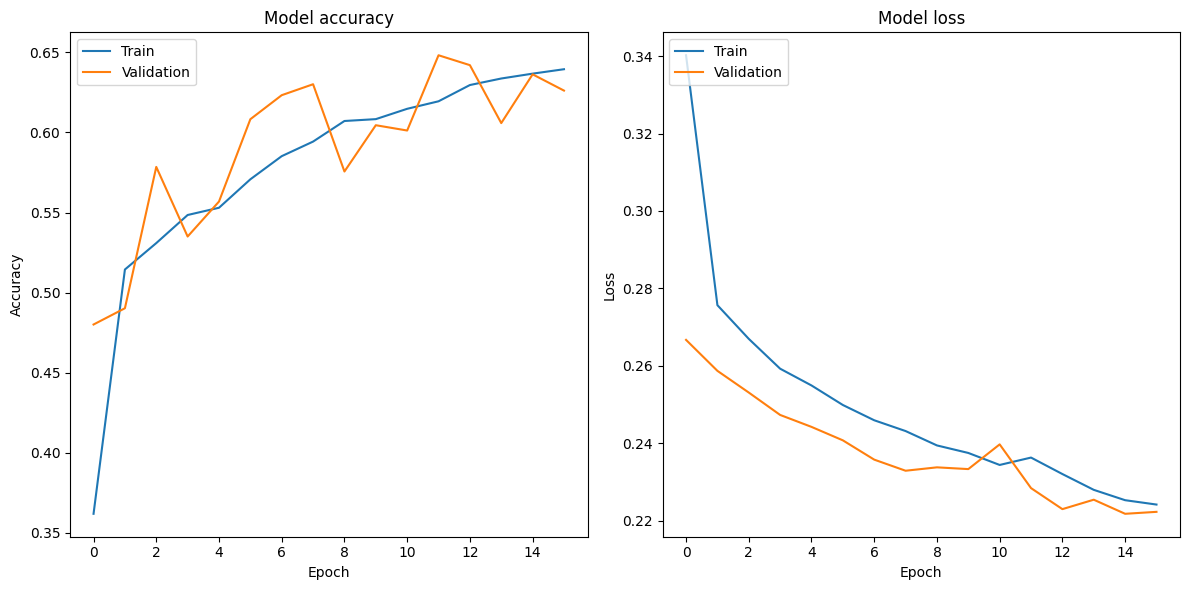

In [18]:
# Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(best_history.history['accuracy'])
plt.plot(best_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Loss
plt.subplot(1, 2, 2)
plt.plot(best_history.history['loss'])
plt.plot(best_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [19]:
test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.2262
Test Accuracy: 0.6373


In [20]:
# Predict classes using the cnn model
y_pred_cnn = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred_cnn, axis=1)

177/177 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step


Metrics for Class 0:


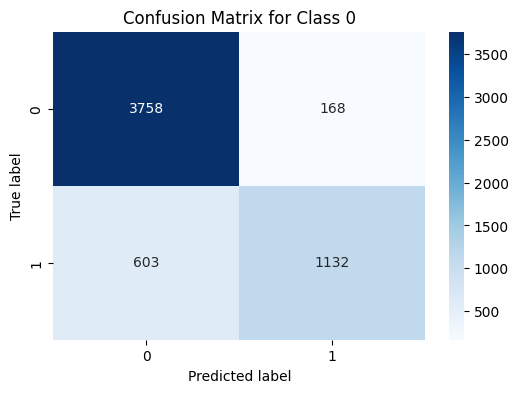

  Sensitivity (SEV): 0.6524
  Specificity (SPE): 0.9572
  Accuracy: 0.8638
  F1-score: 0.7460

Metrics for Class 1:


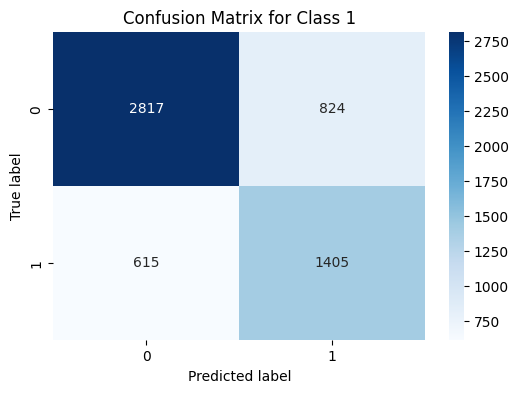

  Sensitivity (SEV): 0.6955
  Specificity (SPE): 0.7737
  Accuracy: 0.7458
  F1-score: 0.6613

Metrics for Class 2:


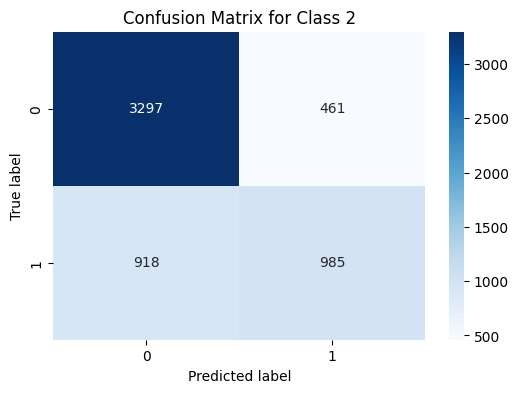

  Sensitivity (SEV): 0.5176
  Specificity (SPE): 0.8773
  Accuracy: 0.7564
  F1-score: 0.5882

Metrics for Class 3:


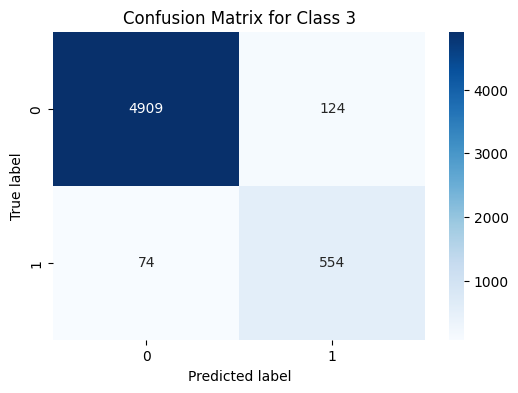

  Sensitivity (SEV): 0.8822
  Specificity (SPE): 0.9754
  Accuracy: 0.9650
  F1-score: 0.8484

Metrics for Class 4:


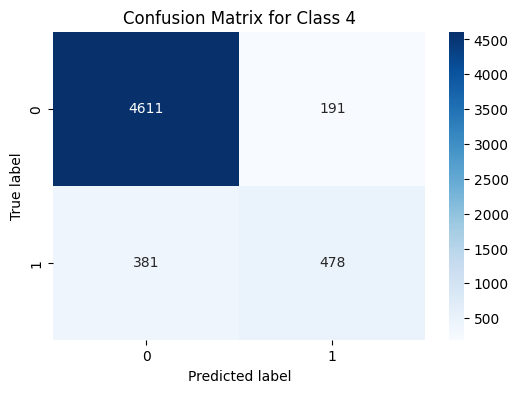

  Sensitivity (SEV): 0.5565
  Specificity (SPE): 0.9602
  Accuracy: 0.8990
  F1-score: 0.6257

Metrics for Class 5:


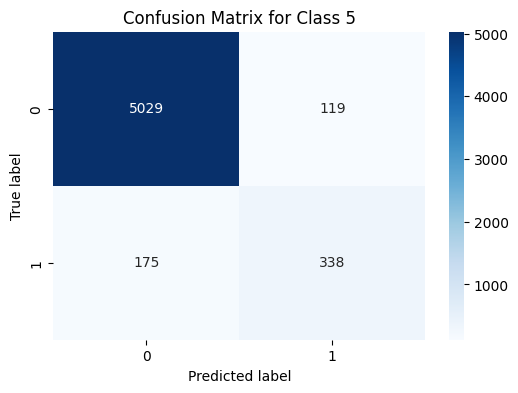

  Sensitivity (SEV): 0.6589
  Specificity (SPE): 0.9769
  Accuracy: 0.9481
  F1-score: 0.6969

Metrics for Class 6:


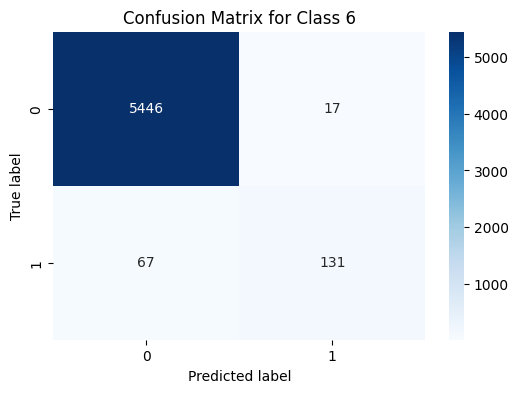

  Sensitivity (SEV): 0.6616
  Specificity (SPE): 0.9969
  Accuracy: 0.9852
  F1-score: 0.7572

Metrics for Class 7:


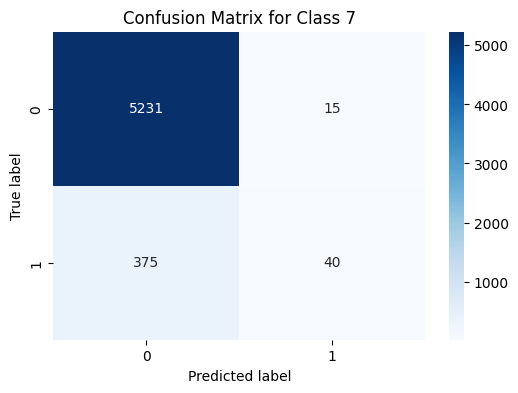

  Sensitivity (SEV): 0.0964
  Specificity (SPE): 0.9971
  Accuracy: 0.9311
  F1-score: 0.1702

Metrics for Class 8:


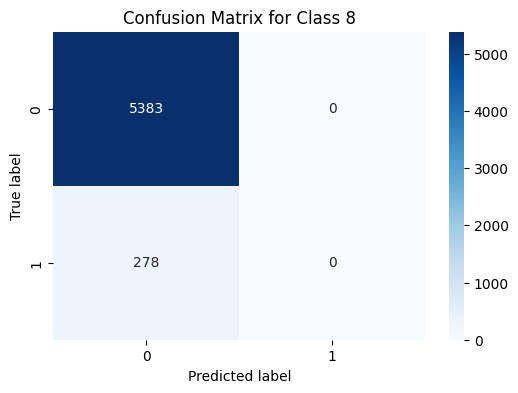

  Sensitivity (SEV): 0.0000
  Specificity (SPE): 1.0000
  Accuracy: 0.9509
  F1-score: 0.0000

Metrics for Class 9:


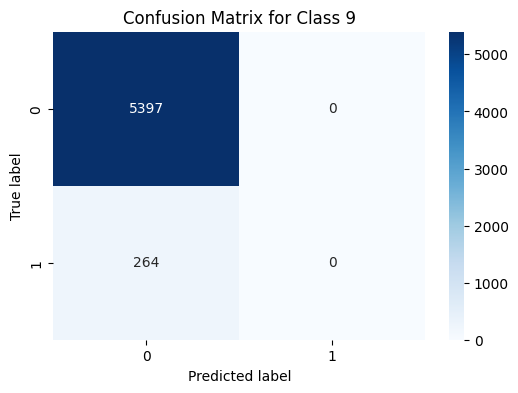

  Sensitivity (SEV): 0.0000
  Specificity (SPE): 1.0000
  Accuracy: 0.9534
  F1-score: 0.0000

Metrics for Class 10:


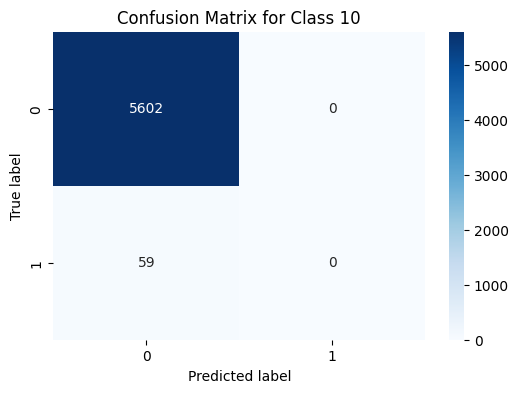

  Sensitivity (SEV): 0.0000
  Specificity (SPE): 1.0000
  Accuracy: 0.9896
  F1-score: 0.0000



In [21]:
# Confusion matrix
# The confusion_matrix function is designed for multiclass or binary classification,
# but y_test is a multilabel-indicator format.
# To handle this, we will calculate metrics for each class separately.

y_test_np = np.array(y_test)

for i in range(y_test_np.shape[1]):  # Iterate over each class
    print(f'Metrics for Class {i}:')
    # Extract true and predicted labels for the current class
    y_true_class = y_test_np[:, i]
    y_pred_class = y_pred_cnn[:, i] > 0.5  # Assuming a threshold of 0.5 for prediction

    # Calculate confusion matrix for the current class
    # Ensure that we have both positive and negative samples in the test set for the class
    if np.sum(y_true_class) > 0 and np.sum(1 - y_true_class) > 0:
        matrix = confusion_matrix(y_true_class, y_pred_class)

        # Plot confusion matrix for the current class
        plt.figure(figsize=(6, 4))
        sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.title(f'Confusion Matrix for Class {i}')
        plt.show()

        # Calculate Sensitivity (SEV) and Specificity (SPE)
        tn, fp, fn, tp = matrix.ravel()
        f1 = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0  # F1-score
        sev = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensitivity (Recall)
        spe = tn / (tn + fp) if (tn + fp) > 0 else 0  # Specificity
        accuracy = (tn + tp) / (tp + fn + tn + fp)

        print(f'  Sensitivity (SEV): {sev:.4f}')
        print(f'  Specificity (SPE): {spe:.4f}')
        print(f'  Accuracy: {accuracy:.4f}')
        print(f'  F1-score: {f1:.4f}\n')
    else:
        print(f"  Skipping metrics for Class {i} as there are no positive or negative samples in the test set.\n")